In [1]:
!unzip /content/drive/MyDrive/vegetables_detection.zip

Archive:  /content/drive/MyDrive/vegetables_detection.zip
   creating: vegetables_detection/
  inflating: vegetables_detection/.DS_Store  
  inflating: __MACOSX/vegetables_detection/._.DS_Store  
   creating: vegetables_detection/dataset/
   creating: vegetables_detection/yolov5/
  inflating: vegetables_detection/dataset/.DS_Store  
  inflating: __MACOSX/vegetables_detection/dataset/._.DS_Store  
   creating: vegetables_detection/dataset/images/
   creating: vegetables_detection/dataset/labels/
  inflating: vegetables_detection/yolov5/LICENSE  
  inflating: vegetables_detection/yolov5/requirements.txt  
  inflating: vegetables_detection/yolov5/.pre-commit-config.yaml  
  inflating: vegetables_detection/yolov5/Dockerfile  
  inflating: vegetables_detection/yolov5/val.py  
   creating: vegetables_detection/yolov5/utils/
   creating: vegetables_detection/yolov5/models/
  inflating: vegetables_detection/yolov5/export.py  
  inflating: vegetables_detection/yolov5/README.md  
  inflating: ve

In [2]:
%cd vegetables_detection

/content/vegetables_detection


In [3]:
!rm dataset/labels/classes.txt

In [4]:
!pip install -r yolov5/requirements.txt

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 596 kB 5.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [6]:
%cd dataset

/content/vegetables_detection/dataset


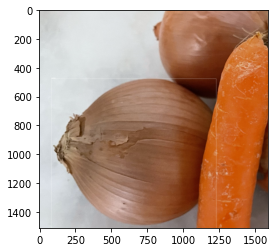

In [7]:
class_name_to_id_mapping = {"lettuce":0,
    "potato":1,
    "carrot":2,
    "onion":3,
    "garlic":4,
    "leek":5,
    "broccoli":6}

random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
annotations = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [8]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('labels', x) for x in os.listdir('labels')]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [9]:
!mkdir images/train images/val images/test labels/train labels/val labels/test

In [10]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')

In [11]:
%cd ../yolov5

/content/vegetables_detection/yolov5


In [12]:
train= "../dataset/images/train/"
val=  "../dataset/images/val/"
test= "../dataset/images/test/"

In [13]:
!python train.py --img 640 --batch 32 --epochs 100 --data vegetables_data.yaml --weights yolov5s.pt --workers 24 --name yolo_veg_det

train: weights=yolov5s.pt, cfg=, data=vegetables_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_veg_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 69 (delta 49), reused 66 (delta 49), pack-reused 3
Unpacking objects: 100% (69/69), done.
From https://github.com/ultralytics/yolov5
   d51f9b2..cf4f3c3  master              -> origin/master
   4762afa..918b7af  test/conv_reduction -> origin/test/conv_reduction
github

In [14]:
!python detect.py --source ../dataset/images/test/ --weights runs/train/yolo_veg_det/weights/best.pt --conf 0.25 --name yolo_veg_det

detect: weights=['runs/train/yolo_veg_det/weights/best.pt'], source=../dataset/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_veg_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 üöÄ v6.1-73-gd51f9b2 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model summary: 213 layers, 7029004 parameters, 0 gradients, 15.9 GFLOPs
image 1/61 /content/vegetables_detection/dataset/images/test/11_rotated.png: 480x640 4 onions, Done. (0.020s)
image 2/61 /content/vegetables_detection/dataset/images/test/15_GaussianBlur.png: 480x640 2 carrots, 4 onions, 1 garlic, 1 leek, Done. (0.020s)
image 3/61 /content/vegetables_detection/dataset/images/test/16_cropped_1.png: 640x320 1 lettuc

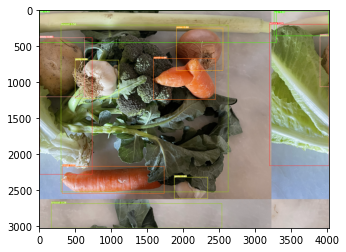

In [17]:
detections_dir = "runs/detect/yolo_veg_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [18]:
!python val.py --weights runs/train/yolo_veg_det/weights/best.pt --data vegetables_data.yaml --task test --name yolo_det

val: data=/content/vegetables_detection/yolov5/data/vegetables_data.yaml, weights=['runs/train/yolo_veg_det/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 üöÄ v6.1-73-gd51f9b2 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model summary: 213 layers, 7029004 parameters, 0 gradients, 15.9 GFLOPs
test: Scanning '/content/vegetables_detection/yolov5/../dataset/labels/test' images and labels...61 found, 0 missing, 0 empty, 0 corrupt: 100% 61/61 [00:01<00:00, 55.51it/s]
test: New cache created: /content/vegetables_detection/yolov5/../dataset/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 2/2 [00:17<00:00,  8.69s/it]
                 all         61        3

In [19]:
!pwd

/content/vegetables_detection/yolov5


In [20]:
%cd ..

/content/vegetables_detection


In [21]:
!zip -r yolo_veg_det.zip yolov5

  adding: yolov5/ (stored 0%)
  adding: yolov5/yolov5s.pt (deflated 9%)
  adding: yolov5/.gitattributes (deflated 4%)
  adding: yolov5/val.py (deflated 66%)
  adding: yolov5/data/ (stored 0%)
  adding: yolov5/data/xView.yaml (deflated 58%)
  adding: yolov5/data/VisDrone.yaml (deflated 59%)
  adding: yolov5/data/coco128.yaml (deflated 50%)
  adding: yolov5/data/images/ (stored 0%)
  adding: yolov5/data/images/zidane.jpg (deflated 0%)
  adding: yolov5/data/images/bus.jpg (deflated 1%)
  adding: yolov5/data/SKU-110K.yaml (deflated 52%)
  adding: yolov5/data/vegetables_data.yaml (deflated 40%)
  adding: yolov5/data/coco.yaml (deflated 52%)
  adding: yolov5/data/VOC.yaml (deflated 56%)
  adding: yolov5/data/scripts/ (stored 0%)
  adding: yolov5/data/scripts/get_coco128.sh (deflated 36%)
  adding: yolov5/data/scripts/get_coco.sh (deflated 47%)
  adding: yolov5/data/scripts/download_weights.sh (deflated 37%)
  adding: yolov5/data/hyps/ (stored 0%)
  adding: yolov5/data/hyps/hyp.scratch-low.ya

In [22]:
!cp yolo_veg_det.zip /content/drive/MyDrive